## Observations and Insights 

#### Key Take aways from the data analysis
*   Without any doubt, the best treatments are the Capomulin and Ramicane, because these two factors:
 (i) the tumor size is largely reduced after the time period of the treatment (mean of 40.67 for Capomulin and 40.21 for Ramicane) 
 (ii) the number of suvival mice at the end of day 45 are also among the largest within the treatments (21 for Capomulin and 20 for Ramicane) 

* It is worth to note the behavior of regimens like Katapril, Naftisol and Stelasyn.
 When we compare their mean against the mean of Placebo it seems like these treatments did not show any improvement at all in the size of tumor. 
 
* Regarding the relationship between mouse weight and tumor volume, they appear not to be correlated when we look at the Pearson correlation (0.53) and the r2 (0.2763) 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import sem
from scipy.stats import linregress
from sklearn import datasets
from sklearn.datasets import load_boston

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
combined_data = pd.merge(study_results, mouse_metadata, on = "Mouse ID", how="left")
combined_data.head(3)

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29


In [2]:
# Checking the number of mice in the DataFrame.
number_of_mice= combined_data["Mouse ID"].nunique()
observations= combined_data["Mouse ID"].count()
n_mice = pd.DataFrame({
                      "Number of unique mice":[number_of_mice],
                      "Total mice observations":[observations]
                      })
n_mice

,Number of unique mice,Total mice observations
0,249,1893


In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mice_duplicated = combined_data.loc[combined_data.duplicated(subset=["Mouse ID","Timepoint"]), "Mouse ID"].unique() 
mice_duplicated

array(['g989'], dtype=object)

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
combined_data.loc[combined_data["Mouse ID"]=="g989"]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
clean_df = combined_data[combined_data["Mouse ID"].isin(mice_duplicated)==False ]
clean_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [6]:
# Checking the number of mice in the clean DataFrame.
number_of_mice= clean_df["Mouse ID"].nunique()
observations= clean_df["Mouse ID"].count()
n_mice = pd.DataFrame({
                       "Number of unique mice":[number_of_mice],
                      "Total mice observations":[observations]
                      })
n_mice

,Number of unique mice,Total mice observations
0,248,1880


## Summary Statistics

In [7]:
drug_counts = clean_df["Drug Regimen"].value_counts()
drug_counts

Capomulin    230
Ramicane     228
Ketapril     188
Naftisol     186
Zoniferol    182
Stelasyn     181
Placebo      181
Infubinol    178
Ceftamin     178
Propriva     148
Name: Drug Regimen, dtype: int64

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straighforward, creating multiple series and putting them all together at the end.
mean = clean_df.groupby("Drug Regimen").mean()["Tumor Volume (mm3)"]
median = clean_df.groupby("Drug Regimen").median()["Tumor Volume (mm3)"]
variance = clean_df.groupby("Drug Regimen").var()["Tumor Volume (mm3)"]
stdev = clean_df.groupby("Drug Regimen").std()["Tumor Volume (mm3)"]
sem = clean_df.groupby("Drug Regimen").sem()["Tumor Volume (mm3)"]
stats = pd.DataFrame({
                      "Mean": mean,
                      "Median":median,
                      "Variance": variance,
                      "Std Dev": stdev,
                      "SEM":sem
                      })
stats

,Mean,Median,Variance,Std Dev,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
stats_bis = clean_df.groupby("Drug Regimen").agg({"Tumor Volume (mm3)":["mean","median","var","std", "sem"]})
stats_bis

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar Plots

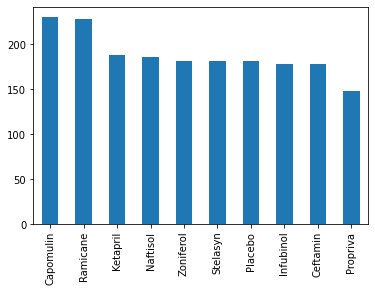

In [10]:
# Generate a bar plot showing the number of mice per time point for each treatment
#throughout the course of the study using pandas. 
drug_counts = clean_df["Drug Regimen"].value_counts()
drug_counts.plot(kind="bar")
plt.show()

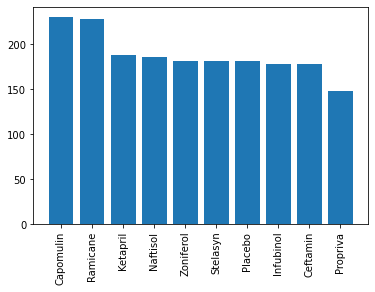

In [11]:
# Generate a bar plot showing the number of mice per time point for each treatment
#throughout the course of the study using pyplot.
drug_counts = clean_df["Drug Regimen"].value_counts()
x_values = drug_counts.index.values
y_values = drug_counts.values
plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.show()

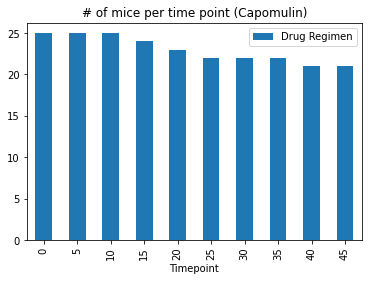

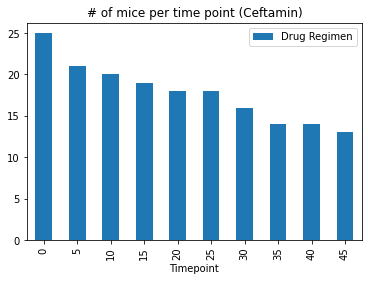

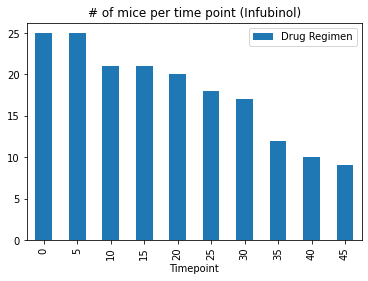

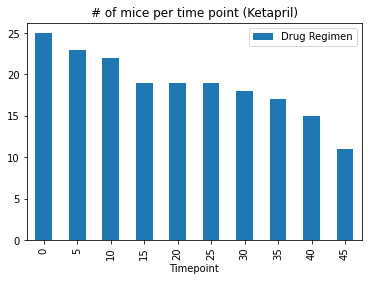

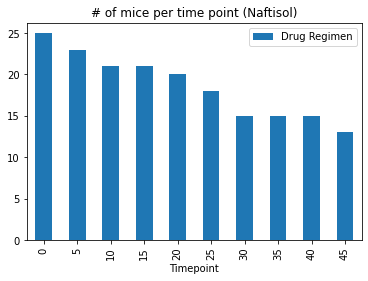

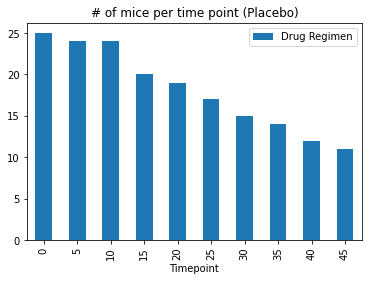

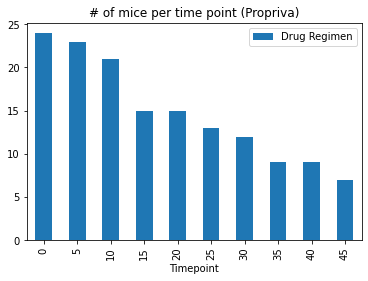

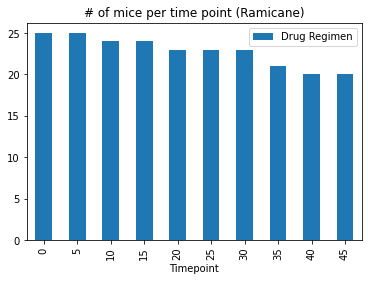

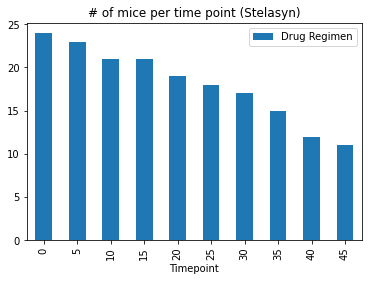

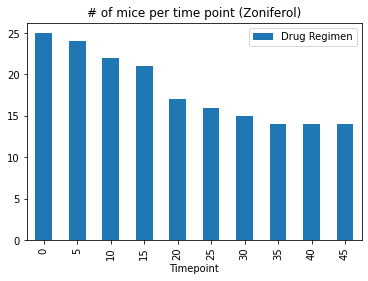

In [12]:
# ALTERNATIVELY I CREATED BAR PLOTS BY EACH REGIME SHOWING THE EVOLUTION OF THE NUMBER OF MICE ALONG THE TIMEPOINT
# THIS WOULD HELP US TO HAVE A VISUAL INSIGHT OF HOW MICE WERE LOST DURING THE TEST PERIOD USING PANDAS

Capomulin_df = clean_df.loc[(clean_df["Drug Regimen"]=="Capomulin")]
Capomulin_bar = Capomulin_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Capomulin_bar.plot(kind="bar", title="# of mice per time point (Capomulin)")

Ceftamin_df = clean_df.loc[(clean_df["Drug Regimen"]=="Ceftamin")]
Ceftamin_bar = Ceftamin_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Ceftamin_bar.plot(kind="bar", title="# of mice per time point (Ceftamin)")

Infubinol_df = clean_df.loc[(clean_df["Drug Regimen"]=="Infubinol")]
Infubinol_bar = Infubinol_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Infubinol_bar.plot(kind="bar", title="# of mice per time point (Infubinol)")

Ketapril_df = clean_df.loc[(clean_df["Drug Regimen"]=="Ketapril")]
Ketapril_bar = Ketapril_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Ketapril_bar.plot(kind="bar", title="# of mice per time point (Ketapril)")

Naftisol_df = clean_df.loc[(clean_df["Drug Regimen"]=="Naftisol")]
Naftisol_bar = Naftisol_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Naftisol_bar.plot(kind="bar", title="# of mice per time point (Naftisol)")

Placebo_df = clean_df.loc[(clean_df["Drug Regimen"]=="Placebo")]
Placebo_bar = Placebo_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Placebo_bar.plot(kind="bar", title="# of mice per time point (Placebo)")

Propriva_df = clean_df.loc[(clean_df["Drug Regimen"]=="Propriva")]
Propriva_bar = Propriva_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Propriva_bar.plot(kind="bar", title="# of mice per time point (Propriva)")

Ramicane_df = clean_df.loc[(clean_df["Drug Regimen"]=="Ramicane")]
Ramicane_bar = Ramicane_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Ramicane_bar.plot(kind="bar", title="# of mice per time point (Ramicane)")

Stelasyn_df = clean_df.loc[(clean_df["Drug Regimen"]=="Stelasyn")]
Stelasyn_bar = Stelasyn_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Stelasyn_bar.plot(kind="bar", title="# of mice per time point (Stelasyn)")

Zoniferol_df = clean_df.loc[(clean_df["Drug Regimen"]=="Zoniferol")]
Zoniferol_bar = Zoniferol_df[["Drug Regimen","Timepoint"]].groupby("Timepoint").count()
Zoniferol_bar.plot(kind="bar", title="# of mice per time point (Zoniferol)")

## Pie Plots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C8D94FC70>],
      dtype=object)

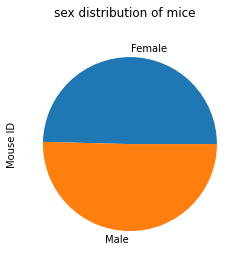

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
sex_pie = clean_df[["Sex","Mouse ID"]].groupby("Sex").nunique()
sex_pie = sex_pie["Mouse ID"]
sex_pie.plot(kind="pie", title="sex distribution of mice", subplots =True)

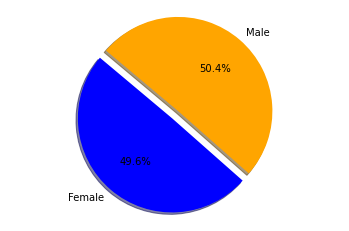

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
sex_pie = clean_df[["Sex","Mouse ID"]].groupby("Sex").nunique()
sex_pie = sex_pie["Mouse ID"]
pie_label = [sex_pie.index[0],sex_pie.index[1]]
pie_size =  [sex_pie[0],sex_pie[1]]
colors = ["blue","orange"]
explode = (0.1,0)
plt.pie(colors=colors, x = pie_size, labels = pie_label, autopct="%1.1f%%", shadow=True, startangle=140,explode=explode)
plt.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens.
# Capomulin, Ramicane, Infubinol, Ceftamin
# Calculate the IQR and quantitatively determine if there are any potential outliers across all four treatment regimens 

In [16]:
# Final tumor volume of each mouse across Capomulin
Capomulin_tp45 = clean_df.loc[(clean_df["Timepoint"]==45)&(clean_df["Drug Regimen"]=="Capomulin")]
Capomulin_tp45

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
1764,b128,45,38.982878,2,Capomulin,Female,9,22
1769,t565,45,34.455298,0,Capomulin,Female,20,17
1771,l509,45,41.483008,3,Capomulin,Male,17,21
1777,g288,45,37.074024,1,Capomulin,Male,3,19
1788,r554,45,32.377357,3,Capomulin,Female,8,17
1791,g316,45,40.159220,2,Capomulin,Female,22,22
1797,y793,45,31.896238,2,Capomulin,Male,17,17
1800,m957,45,33.329098,1,Capomulin,Female,3,19
1817,l897,45,38.846876,1,Capomulin,Male,17,19
1821,v923,45,40.658124,2,Capomulin,Female,19,21


In [17]:
# Calculate the IQR and quantitatively determine if there are any potential outliers across Capomulin

#The following lines compute the quartiles, IQR, upper & Lower bound
quartiles_Capomulin = Capomulin_tp45["Tumor Volume (mm3)"].quantile([.25,.5,.75])
median_Capomulin = quartiles_Capomulin[0.5]
lowerq_Capomulin = quartiles_Capomulin[0.25]
upperq_Capomulin = quartiles_Capomulin[0.75]
iqr_Capomulin = upperq_Capomulin - lowerq_Capomulin
lower_bound_Capomulin = lowerq_Capomulin - (iqr_Capomulin * 1.5)
upper_bound_Capomulin = upperq_Capomulin + (iqr_Capomulin * 1.5)
print(f'The lower quartile of Capomulin is: {lowerq_Capomulin}')
print(f'The upper quartile of Capomulin is: {upperq_Capomulin}')
print(f'The interquartile range of Capomulin is: {iqr_Capomulin}')
print(f'The median of Capomulin is: {median_Capomulin}')
print(f'Values below {lower_bound_Capomulin} could be outliers')
print(f'Values above {upper_bound_Capomulin} could be outliers')

#We get a list just with the values from Tumor Volume and no Index
tp45list_Capomulin = Capomulin_tp45["Tumor Volume (mm3)"]
tp45list_Capomulin = tp45list_Capomulin.reset_index(drop = True)

#This loop is to parse the previously formed list to search for outliers
outliers_Capomulin = []
for x in range(len(tp45list_Capomulin)):
    if tp45list_Capomulin[x]<lower_bound_Capomulin or tp45list_Capomulin[x]>upper_bound_Capomulin:    
        #print(tp45list_Capomulin[x]) ### This line was added for testing purposes
        outliers_Capomulin.append(tp45list_Capomulin[x])
print(f'Number of outliers in Capomulin Regimen are: {len(outliers_Capomulin)}')
outliers_Capomulin

The lower quartile of Capomulin is: 32.37735684
The upper quartile of Capomulin is: 40.1592203
The interquartile range of Capomulin is: 7.781863460000004
The median of Capomulin is: 37.31184577
Values below 20.70456164999999 could be outliers
Values above 51.83201549 could be outliers
Number of outliers in Capomulin Regimen are: 0


[]

In [18]:
# Final tumor volume of each mouse across Ramicane
Ramicane_tp45 = clean_df.loc[(clean_df["Timepoint"]==45)&(clean_df["Drug Regimen"]=="Ramicane")]
Ramicane_tp45

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
1763,n364,45,31.095335,1,Ramicane,Male,4,17
1773,a411,45,38.407618,1,Ramicane,Male,3,22
1776,q597,45,45.220869,2,Ramicane,Male,20,25
1780,i334,45,36.374510,2,Ramicane,Female,8,20
1795,s508,45,30.276232,0,Ramicane,Male,1,17
1799,z578,45,30.638696,0,Ramicane,Male,11,16
1801,e662,45,40.659006,2,Ramicane,Male,8,24
1808,m546,45,30.564625,1,Ramicane,Male,18,16
1814,k403,45,22.050126,1,Ramicane,Male,21,16
1822,c758,45,33.397653,1,Ramicane,Male,9,17


In [19]:
# Calculate the IQR and quantitatively determine if there are any potential outliers across Ramicane

#The following lines compute the quartiles, IQR, upper & Lower bound
quartiles_Ramicane = Ramicane_tp45["Tumor Volume (mm3)"].quantile([.25,.5,.75])
median_Ramicane = quartiles_Ramicane[0.5]
lowerq_Ramicane = quartiles_Ramicane[0.25]
upperq_Ramicane = quartiles_Ramicane[0.75]
iqr_Ramicane = upperq_Ramicane - lowerq_Ramicane
lower_bound_Ramicane = lowerq_Ramicane - (iqr_Ramicane * 1.5)
upper_bound_Ramicane = upperq_Ramicane + (iqr_Ramicane * 1.5)
print(f'The lower quartile of Ramicane is: {lowerq_Ramicane}')
print(f'The upper quartile of Ramicane is: {upperq_Ramicane}')
print(f'The interquartile range of Ramicane is: {iqr_Ramicane}')
print(f'The median of Ramicane is: {median_Ramicane}')
print(f'Values below {lower_bound_Ramicane} could be outliers')
print(f'Values above {upper_bound_Ramicane} could be outliers')

#We get a list just with the values from Tumor Volume and no Index
tp45list_Ramicane = Ramicane_tp45["Tumor Volume (mm3)"]
tp45list_Ramicane = tp45list_Ramicane.reset_index(drop = True)

#This loop is to parse the previously formed list to search for outliers
outliers_Ramicane = []
for x in range(len(tp45list_Ramicane)):
    if tp45list_Ramicane[x]<lower_bound_Ramicane or tp45list_Ramicane[x]>upper_bound_Ramicane:    
        #print(tp45list_Ramicane[x]) ### This line was added for testing purposes
        outliers_Ramicane.append(tp45list_Ramicane[x])
print(f'Number of outliers in Ramicane Regimen are: {len(outliers_Ramicane)}')
outliers_Ramicane

The lower quartile of Ramicane is: 30.981175224999998
The upper quartile of Ramicane is: 38.508305307499995
The interquartile range of Ramicane is: 7.527130082499998
The median of Ramicane is: 34.848627300000004
Values below 19.690480101250003 could be outliers
Values above 49.79900043124999 could be outliers
Number of outliers in Ramicane Regimen are: 0


[]

In [20]:
# Final tumor volume of each mouse across Infubinol
Infubinol_tp45 = clean_df.loc[(clean_df["Timepoint"]==45)&(clean_df["Drug Regimen"]=="Infubinol")]
Infubinol_tp45

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
1779,y163,45,67.685569,3,Infubinol,Female,17,27
1781,c139,45,72.226731,2,Infubinol,Male,11,28
1784,z581,45,62.754451,3,Infubinol,Female,24,25
1786,a251,45,65.525743,1,Infubinol,Female,21,25
1789,k483,45,66.196912,3,Infubinol,Female,20,30
1794,a685,45,66.083066,3,Infubinol,Male,8,30
1802,e476,45,62.435404,1,Infubinol,Male,23,26
1804,a203,45,67.973419,2,Infubinol,Female,20,23
1806,f345,45,60.918767,1,Infubinol,Male,23,26


In [21]:
# Calculate the IQR and quantitatively determine if there are any potential outliers across Infubinol

#The following lines compute the quartiles, IQR, upper & Lower bound
quartiles_Infubinol = Infubinol_tp45["Tumor Volume (mm3)"].quantile([.25,.5,.75])
median_Infubinol = quartiles_Infubinol[0.5]
lowerq_Infubinol = quartiles_Infubinol[0.25]
upperq_Infubinol = quartiles_Infubinol[0.75]
iqr_Infubinol = upperq_Infubinol - lowerq_Infubinol
lower_bound_Infubinol = lowerq_Infubinol - (iqr_Infubinol * 1.5)
upper_bound_Infubinol = upperq_Infubinol + (iqr_Infubinol * 1.5)
print(f'The lower quartile of Infubinol is: {lowerq_Infubinol}')
print(f'The upper quartile of Infubinol is: {upperq_Infubinol}')
print(f'The interquartile range of Infubinol is: {iqr_Infubinol}')
print(f'The median of Infubinol is: {median_Infubinol}')
print(f'Values below {lower_bound_Infubinol} could be outliers')
print(f'Values above {upper_bound_Infubinol} could be outliers')

#We get a list just with the values from Tumor Volume and no Index
tp45list_Infubinol = Infubinol_tp45["Tumor Volume (mm3)"]
tp45list_Infubinol = tp45list_Infubinol.reset_index(drop = True)

#This loop is to parse the previously formed list to search for outliers
outliers_Infubinol = []
for x in range(len(tp45list_Infubinol)):
    if tp45list_Infubinol[x]<lower_bound_Infubinol or tp45list_Infubinol[x]>upper_bound_Infubinol:    
        #print(tp45list_Infubinol[x]) ### This line was added for testing purposes
        outliers_Infubinol.append(tp45list_Infubinol[x])
print(f'Number of outliers in Infubinol Regimen are: {len(outliers_Infubinol)}')
outliers_Infubinol

The lower quartile of Infubinol is: 62.75445141
The upper quartile of Infubinol is: 67.68556862
The interquartile range of Infubinol is: 4.9311172099999965
The median of Infubinol is: 66.08306589
Values below 55.35777559500001 could be outliers
Values above 75.08224443499999 could be outliers
Number of outliers in Infubinol Regimen are: 0


[]

In [22]:
# Final tumor volume of each mouse across Ceftamin
Ceftamin_tp45 = clean_df.loc[(clean_df["Timepoint"]==45)&(clean_df["Drug Regimen"]=="Ceftamin")]
Ceftamin_tp45

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
1765,l661,45,59.851956,3,Ceftamin,Male,18,26
1766,y865,45,64.729837,3,Ceftamin,Male,23,26
1767,y769,45,68.594745,4,Ceftamin,Female,6,27
1772,j296,45,61.849023,3,Ceftamin,Female,24,30
1790,w151,45,67.527482,3,Ceftamin,Male,24,25
1810,l471,45,67.748662,1,Ceftamin,Female,7,28
1855,x581,45,64.634949,3,Ceftamin,Female,19,28
1856,a275,45,62.999356,3,Ceftamin,Female,20,28
1858,k210,45,68.923185,3,Ceftamin,Male,15,28
1862,x822,45,61.386660,3,Ceftamin,Male,3,29


In [23]:
# Calculate the IQR and quantitatively determine if there are any potential outliers across Ceftamin

#The following lines compute the quartiles, IQR, upper & Lower bound
quartiles_Ceftamin = Ceftamin_tp45["Tumor Volume (mm3)"].quantile([.25,.5,.75])
median_Ceftamin = quartiles_Ceftamin[0.5]
lowerq_Ceftamin = quartiles_Ceftamin[0.25]
upperq_Ceftamin = quartiles_Ceftamin[0.75]
iqr_Ceftamin = upperq_Ceftamin - lowerq_Ceftamin
lower_bound_Ceftamin = lowerq_Ceftamin - (iqr_Ceftamin * 1.5)
upper_bound_Ceftamin = upperq_Ceftamin + (iqr_Ceftamin * 1.5)
print(f'The lower quartile of Ceftamin is: {lowerq_Ceftamin}')
print(f'The upper quartile of Ceftamin is: {upperq_Ceftamin}')
print(f'The interquartile range of Ceftamin is: {iqr_Ceftamin}')
print(f'The median of Ceftamin is: {median_Ceftamin}')
print(f'Values below {lower_bound_Ceftamin} could be outliers')
print(f'Values above {upper_bound_Ceftamin} could be outliers')

#We get a list just with the values from Tumor Volume and no Index
tp45list_Ceftamin = Ceftamin_tp45["Tumor Volume (mm3)"]
tp45list_Ceftamin = tp45list_Ceftamin.reset_index(drop = True)

#if tp45list_Ceftamin[x]<65 or tp45list_Ceftamin[x]>upper_bound_Ceftamin: ### This line was added for testing purposes
#This loop is to parse the previously formed list to search for outliers
outliers_Ceftamin = []
for x in range(len(tp45list_Ceftamin)):
    if tp45list_Ceftamin[x]<lower_bound_Ceftamin or tp45list_Ceftamin[x]>upper_bound_Ceftamin:    
        #print(tp45list_Ceftamin[x]) ### This line was added for testing purposes
        outliers_Ceftamin.append(tp45list_Ceftamin[x])
print(f'Number of outliers in Ceftamin Regimen are: {len(outliers_Ceftamin)}')
outliers_Ceftamin

The lower quartile of Ceftamin is: 61.43389223
The upper quartile of Ceftamin is: 67.52748237
The interquartile range of Ceftamin is: 6.093590140000003
The median of Ceftamin is: 64.29983003
Values below 52.29350701999999 could be outliers
Values above 76.66786758 could be outliers
Number of outliers in Ceftamin Regimen are: 0


[]

In [24]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

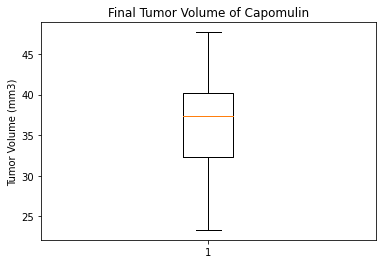

In [25]:
# Box plot of the final tumor volume of Capomulin
fig1, ax1 = plt.subplots()
ax1.set_title("Final Tumor Volume of Capomulin")
ax1.set_ylabel ("Tumor Volume (mm3)")
ax1.boxplot(tp45list_Capomulin)
plt.show()
#tp45list_Capomulin

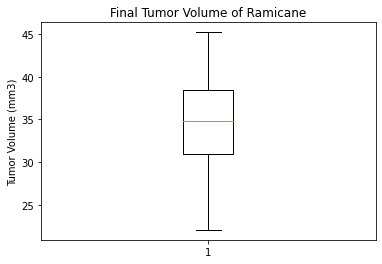

In [26]:
# Box plot of the final tumor volume of Ramicane
fig2, ax2 = plt.subplots()
ax2.set_title("Final Tumor Volume of Ramicane")
ax2.set_ylabel ("Tumor Volume (mm3)")
ax2.boxplot(tp45list_Ramicane)
plt.show()
#tp45list_Ramicane

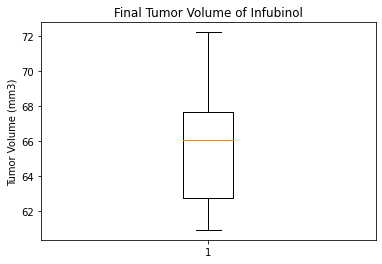

In [27]:
# Box plot of the final tumor volume of Infubinol
fig3, ax3 = plt.subplots()
ax3.set_title("Final Tumor Volume of Infubinol")
ax3.set_ylabel ("Tumor Volume (mm3)")
ax3.boxplot(tp45list_Infubinol)
plt.show()
#tp45list_Infubinol

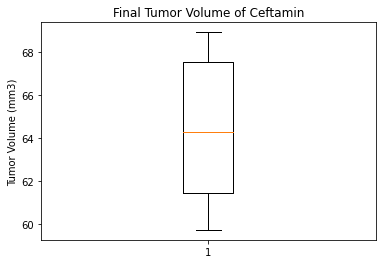

In [28]:
# Box plot of the final tumor volume of Ceftamin
fig4, ax4 = plt.subplots()
ax4.set_title("Final Tumor Volume of Ceftamin")
ax4.set_ylabel ("Tumor Volume (mm3)")
ax4.boxplot(tp45list_Ceftamin)
plt.show()
#tp45list_Ceftamin

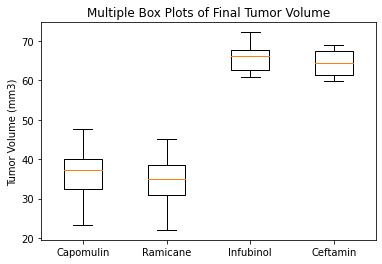

In [29]:
# Box plot of the final tumor volume of each mouse across four regimens of interest COMBINED
fig5, ax5 = plt.subplots()
combined_data = [tp45list_Capomulin,tp45list_Ramicane,tp45list_Infubinol,tp45list_Ceftamin]
ax5.set_title("Multiple Box Plots of Final Tumor Volume")
ax5.set_ylabel ("Tumor Volume (mm3)")
ax5.boxplot(combined_data)
labels = ("Capomulin","Ramicane","Infubinol","Ceftamin")
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()

## Line and Scatter Plots

Insert Mouse Id:g288


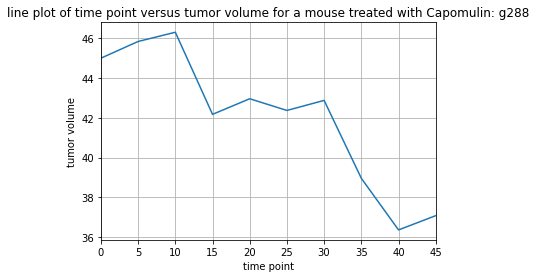

In [30]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
#r157, s185, x401, m601, i557, r944, f966, l509, s710, g316, u364, v923, w150
#y793, r554, m957, j119, t565, j246, b128, b742, i738, l897, w914, g288

mouse = input("Insert Mouse Id:")
Capomulin_mouse = clean_df.loc[(clean_df["Mouse ID"]==mouse)&(clean_df["Drug Regimen"]=="Capomulin")]
#Capomulin_mouse

tp_mouse = Capomulin_mouse["Timepoint"]
tp_mouse = tp_mouse.reset_index(drop = True)
tvolume_mouse = Capomulin_mouse["Tumor Volume (mm3)"]
tvolume_mouse = tvolume_mouse.reset_index(drop = True)

plt.plot(tp_mouse, tvolume_mouse)
plt.title(f"line plot of time point versus tumor volume for a mouse treated with Capomulin: {mouse}")
plt.xlabel("time point")
plt.ylabel("tumor volume")
plt.xlim(0,45)
plt.grid()
plt.show()

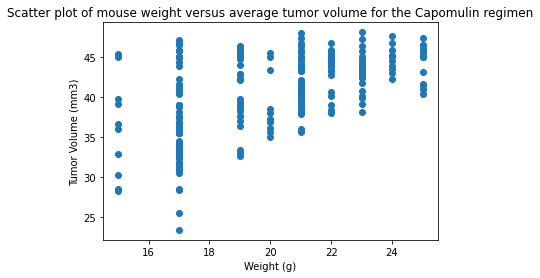

In [31]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
Capomulin_df = clean_df.loc[(clean_df["Drug Regimen"]=="Capomulin")]
Capomulin_weight = Capomulin_df["Weight (g)"]
Capomulin_weight = Capomulin_weight.reset_index(drop = True)
Capomulin_TVolume = Capomulin_df["Tumor Volume (mm3)"]
Capomulin_TVolume = Capomulin_TVolume.reset_index(drop = True)
plt.scatter (Capomulin_weight, Capomulin_TVolume)
plt.title("Scatter plot of mouse weight versus average tumor volume for the Capomulin regimen")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

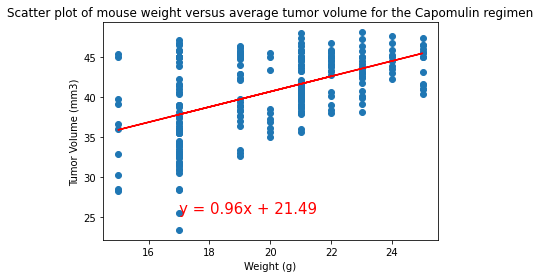

The linear regression model for mouse weight and average tumor volume for the Capomulin regimen is: y = 0.96x + 21.49
The correlation coefficient between Weight and Tumor Volume for the Capomulin regimen is 0.53
The r-squared (goodness of fit) is: 0.2763600223455914


In [32]:
# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen

correlation = st.pearsonr(Capomulin_weight, Capomulin_TVolume)
(slope, intercept, rvalue, pvalue, stderr) = linregress(Capomulin_weight, Capomulin_TVolume)
regress_values = Capomulin_weight * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(Capomulin_weight, Capomulin_TVolume)
plt.plot(Capomulin_weight, regress_values,"r-")
plt.annotate(line_eq,(17,25.47214326),fontsize=15,color="red")
plt.title("Scatter plot of mouse weight versus average tumor volume for the Capomulin regimen")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

print(f'The linear regression model for mouse weight and average tumor volume for the Capomulin regimen is: {line_eq}')
print(f"The correlation coefficient between Weight and Tumor Volume for the Capomulin regimen is {round(correlation[0],2)}")
print(f"The r-squared (goodness of fit) is: {rvalue**2}")

In [33]:
# Calculate the correlation matrix for mouse weight and average tumor volume for the Capomulin regimen
correl_matrix = clean_df.loc[(clean_df["Drug Regimen"]=="Capomulin")]
correl_matrix = correl_matrix[["Weight (g)","Tumor Volume (mm3)"]]
correl_matrix = correl_matrix.corr()
correl_matrix.unstack().sort_values()

Weight (g)          Tumor Volume (mm3)    0.5257
Tumor Volume (mm3)  Weight (g)            0.5257
Weight (g)          Weight (g)            1.0000
Tumor Volume (mm3)  Tumor Volume (mm3)    1.0000
dtype: float64